In [27]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.linear_model import LogisticRegression
from sklearn.multiclass import OneVsOneClassifier
from sklearn.metrics import accuracy_score

from sklearn.model_selection import GroupKFold
from sklearn.metrics import roc_auc_score
import xgboost as xgb

import warnings
warnings.filterwarnings('ignore')


pd.set_option('display.max_columns', 150)

In [28]:
path1 = '/Users/zamiulalam/Documents/Fraud/ieee-fraud-detection/train_identity.csv'
path2 = '/Users/zamiulalam/Documents/Fraud/ieee-fraud-detection/train_transaction.csv'
path3 = '/Users/zamiulalam/Documents/Fraud/ieee-fraud-detection/test_identity.csv'
path4 = '/Users/zamiulalam/Documents/Fraud/ieee-fraud-detection/test_transaction.csv'

id = pd.read_csv(path1)
tranz = pd.read_csv(path2)
id_test = pd.read_csv(path3)
tranz_test = pd.read_csv(path4)

In [29]:
id_test.columns = [col.replace('-', '_') for col in id_test.columns]

In [30]:
tranz = tranz.merge(id, how='left', on='TransactionID')
tranz_test = tranz_test.merge(id_test, how = 'left', on = 'TransactionID')

In [31]:
tranz_test['isFraud'] = np.nan

In [32]:
transaction_features = pd.read_csv('/Users/zamiulalam/Documents/Fraud/ieee-fraud-detection/Transaction_features.txt', header=None)[0].tolist()
id_features = pd.read_csv('/Users/zamiulalam/Documents/Fraud/ieee-fraud-detection/id_features.txt', header=None)[0].tolist()

features_to_keep = set(transaction_features + id_features)
features_to_keep = [col for col in tranz.columns if col in features_to_keep]

tranz = tranz[features_to_keep]
tranz_test = tranz_test[features_to_keep]

In [33]:
tranz.shape

(590540, 156)

In [34]:
#Find the number of missing values in each column
miss_val_tranz = tranz.isnull().sum()

#Turn the missing value counts into percentages
miss_val_per_tranz = (miss_val_tranz/ len(tranz))*100

#Return counts and percentages of missing values in each column
miss_data_tranz = pd.DataFrame({'MIssing Values': miss_val_tranz,'Percentage (%)':miss_val_per_tranz})

print('Columnswith 80 percent of non nan data:')



print(miss_data_tranz[miss_data_tranz['Percentage (%)'] < 80].index.tolist())
print('Number of such columns = ',len(miss_data_tranz[miss_data_tranz['Percentage (%)'] < 80].index.tolist()))

Columnswith 80 percent of non nan data:
['TransactionID', 'isFraud', 'TransactionDT', 'TransactionAmt', 'ProductCD', 'card1', 'card2', 'card3', 'card4', 'card5', 'card6', 'addr1', 'addr2', 'dist1', 'P_emaildomain', 'R_emaildomain', 'C1', 'C2', 'C3', 'C4', 'C5', 'C6', 'C7', 'C8', 'C9', 'C10', 'C11', 'C12', 'C13', 'C14', 'D1', 'D2', 'D3', 'D4', 'D5', 'D10', 'D11', 'D15', 'M1', 'M2', 'M3', 'M4', 'M5', 'M6', 'M7', 'M8', 'M9', 'V1', 'V2', 'V6', 'V10', 'V12', 'V14', 'V19', 'V20', 'V23', 'V25', 'V26', 'V35', 'V37', 'V38', 'V39', 'V44', 'V45', 'V46', 'V53', 'V55', 'V56', 'V61', 'V62', 'V65', 'V66', 'V67', 'V70', 'V72', 'V75', 'V77', 'V81', 'V82', 'V83', 'V86', 'V87', 'V88', 'V89', 'V91', 'V94', 'V95', 'V98', 'V99', 'V107', 'V108', 'V109', 'V115', 'V117', 'V118', 'V120', 'V121', 'V123', 'V124', 'V125', 'V130', 'V135', 'V172', 'V173', 'V188', 'V223', 'V242', 'V258', 'V261', 'V279', 'V281', 'V282', 'V283', 'V284', 'V285', 'V286', 'V288', 'V289', 'V290', 'V294', 'V300', 'V304', 'V305', 'V308', 'V3

In [35]:
tranz = tranz[miss_data_tranz[miss_data_tranz['Percentage (%)'] < 80].index.tolist()]
tranz_test= tranz_test[miss_data_tranz[miss_data_tranz['Percentage (%)'] < 80].index.tolist()]

In [ ]:
"""
Add useful features and factorize categorical features
"""

tranz["TransactionDay"] = np.floor(tranz["TransactionDT"] / (24*60*60))

for i in range(1,10):
    tranz["M"+str(i)] = tranz["M"+str(i)].astype(bool)

tranz_test["TransactionDay"] = np.floor(tranz_test["TransactionDT"] / (24*60*60))


In [38]:
"""
add universal id to dataset
"""
tranz["D1n"] = tranz["TransactionDay"] - tranz["D1"]
tranz['uid'] = tranz["card1"].astype(str) + '_' + tranz["addr1"].astype(str) + '_' + tranz["D1n"].astype(str)

tranz_test["D1n"] = tranz_test["TransactionDay"] - tranz_test["D1"]
tranz_test['uid'] = tranz_test["card1"].astype(str) + '_' + tranz_test["addr1"].astype(str) + '_' + tranz_test["D1n"].astype(str)

In [ ]:
# Step 1: Sort the DataFrame by time so we can check recent transactions efficiently
tranz = tranz.sort_values('TransactionDT').reset_index(drop=True)
tranz_test = tranz_test.sort_values('TransactionDT').reset_index(drop=True)

# Step 2: Create a unique key based on the three columns
tranz['key'] = (
    tranz['TransactionAmt'].astype(str) + '_' +
    tranz['ProductCD'].astype(str) + '_' +
    tranz['card1'].astype(str)
)
tranz_test['key'] = (
    tranz_test['TransactionAmt'].astype(str) + '_' +
    tranz_test['ProductCD'].astype(str) + '_' +
    tranz_test['card1'].astype(str)
)

# Create a boolean column 'key_match' indicating if the same key appears within 50 rows above or below
def add_key_match(df):
    key_arr = df['key'].values
    match = np.zeros(len(df), dtype=bool)
    for i in range(len(df)):
        start = max(0, i - 50)
        end = min(len(df), i + 51)
        window = np.r_[key_arr[start:i], key_arr[i+1:end]]
        if key_arr[i] in window:
            match[i] = True
    df['key_match'] = match

add_key_match(tranz)
add_key_match(tranz_test)




In [40]:
"""
Determines how many transactions of the same amount occur in plus/minus 500 seconds around a given transaction
for both tranz and tranz_test
"""

# For tranz
tranz = tranz.sort_values('TransactionDT').reset_index(drop=True)
tranz['IsDuplicateInWindowz'] = 1

tds = np.asarray(tranz['TransactionDT'].values)
keys = np.asarray(tranz['key'].values)

for i in range(len(tranz)):
    lower = tds[i] - 500
    upper = tds[i] + 500
    start = np.searchsorted(tds, lower, side='left')
    end = np.searchsorted(tds, upper, side='right')
    window_keys = keys[start:end]
    match_count = np.sum(window_keys == keys[i])
    tranz.at[i, 'IsDuplicateInWindowz'] = match_count

# For tranz_test
tranz_test = tranz_test.sort_values('TransactionDT').reset_index(drop=True)
tranz_test['IsDuplicateInWindowz'] = 1

tds_test = np.asarray(tranz_test['TransactionDT'].values)
keys_test = np.asarray(tranz_test['key'].values)

for i in range(len(tranz_test)):
    lower = tds_test[i] - 500
    upper = tds_test[i] + 500
    start = np.searchsorted(tds_test, lower, side='left')
    end = np.searchsorted(tds_test, upper, side='right')
    window_keys = keys_test[start:end]
    match_count = np.sum(window_keys == keys_test[i])
    tranz_test.at[i, 'IsDuplicateInWindowz'] = match_count

tranz = tranz.drop('key',axis =1)
tranz_test = tranz_test.drop('key',axis =1)    

In [41]:
#NORMALIZE D COLUMNS
for i in range(1,16):
    #if i in [1,2,3,5,9]: continue
    if i in [6,7,8,9,12,13,14]: continue
    tranz['D'+str(i)] =  tranz['D'+str(i)] - tranz.TransactionDT/(24*60*60) 
    tranz_test['D'+str(i)] =  tranz_test['D'+str(i)] - tranz_test.TransactionDT/(24*60*60) 

In [42]:
def encode_AG(groupby: str, aggregate_cols: list):
    global tranz, tranz_test
    # Only use numeric columns for aggregation
    numeric_cols = [col for col in aggregate_cols if pd.api.types.is_numeric_dtype(tranz[col])]
    # Compute the mean and std for train
    means = tranz.groupby(groupby)[numeric_cols].transform('mean').add_suffix('_uid_mean')
    stds = tranz.groupby(groupby)[numeric_cols].transform('std').add_suffix('_uid_std')
    tranz = pd.concat([tranz, means, stds], axis=1)

    # Compute the mean and std for test using train group statistics
    group_means = tranz.groupby(groupby)[numeric_cols].mean()
    group_stds = tranz.groupby(groupby)[numeric_cols].std()
    for col in numeric_cols:
        tranz_test[f"{col}_uid_mean"] = tranz_test[groupby].map(group_means[col])
        tranz_test[f"{col}_uid_std"] = tranz_test[groupby].map(group_stds[col])

# aggregate and frequency encoding features
columns_to_encode = []
columns_to_encode += ["TransactionAmt", "TransactionDT", "addr1", "card1", "card2", "card3","V258","V242"]

d_columns = [d for d in tranz.columns if d.startswith("D")] #and len(d) < 4]
#v_columns = [v for v in tranz.columns if v.startswith("V")] #and len(v) < 4]

columns_to_encode += d_columns
#columns_to_encode += v_columns

encode_AG('uid', columns_to_encode)

In [43]:
def encode_FE(cols: list, inplace=False):
    """
    input:
    cols: list of features to frequency encode
    inplace: replace the columns with their frequency encoding. 
    output:
    dataframe with frequency encoded features
    """
    if isinstance(cols, str):
        cols = [cols]

    for col in cols:
        if inplace:
            col_name = col
        else:
            col_name = col + "_FE"
        # Combine both train and test for frequency calculation
        freq = pd.concat([tranz[col], tranz_test[col]]).value_counts(normalize=True)
        tranz[col_name] = tranz[col].map(freq)
        tranz_test[col_name] = tranz_test[col].map(freq)

columns_to_encode = ["addr1", "card1", "card2", "card3", "P_emaildomain", "R_emaildomain",'uid']
encode_FE(columns_to_encode)

In [44]:
'''
tranz['TransactionDTz'] = pd.to_datetime(tranz['TransactionDT'], unit='s', origin=pd.Timestamp('2000-01-01'))
tranz_test['TransactionDTz'] = pd.to_datetime(tranz_test['TransactionDT'], unit='s', origin=pd.Timestamp('2000-01-01'))

tranz['Day'] = tranz['TransactionDTz'].dt.day
tranz_test['Day'] = tranz_test['TransactionDTz'].dt.day

tranz['Hour'] = tranz['TransactionDTz'].dt.hour
tranz_test['Hour'] = tranz_test['TransactionDTz'].dt.hour

del tranz['TransactionDTz']
del tranz_test['TransactionDTz'] 
'''


"\ntranz['TransactionDTz'] = pd.to_datetime(tranz['TransactionDT'], unit='s', origin=pd.Timestamp('2000-01-01'))\ntranz_test['TransactionDTz'] = pd.to_datetime(tranz_test['TransactionDT'], unit='s', origin=pd.Timestamp('2000-01-01'))\n\ntranz['Day'] = tranz['TransactionDTz'].dt.day\ntranz_test['Day'] = tranz_test['TransactionDTz'].dt.day\n\ntranz['Hour'] = tranz['TransactionDTz'].dt.hour\ntranz_test['Hour'] = tranz_test['TransactionDTz'].dt.hour\n\ndel tranz['TransactionDTz']\ndel tranz_test['TransactionDTz'] \n"

In [45]:
tranz['TransactionAmt_third_decimal'] = tranz['TransactionAmt'].apply(lambda x: 'True' if round(x * 1000) % 10 != 0 else 'False')
tranz_test['TransactionAmt_third_decimal'] = tranz_test['TransactionAmt'].apply(lambda x: 'True' if round(x * 1000) % 10 != 0 else 'False')

In [46]:
tranz = tranz.fillna(-999)
tranz_test = tranz_test.fillna(-999)

In [47]:

for col in tranz.select_dtypes(include=['object','bool']).columns:
    tranz[col], _ = pd.factorize(tranz[col])

for col in tranz_test.select_dtypes(include=['object','bool']).columns:
    tranz_test[col], _ = pd.factorize(tranz_test[col])


In [48]:
print("Number of unique uid in tranz:", tranz['uid'].nunique())
print("Number of unique uid in tranz_test:", tranz_test['uid'].nunique())

common_uids = set(tranz['uid']).intersection(set(tranz_test['uid']))
print("Number of common uid in both tranz and tranz_test:", len(common_uids))

Number of unique uid in tranz: 217850
Number of unique uid in tranz_test: 196187
Number of common uid in both tranz and tranz_test: 196187


In [49]:
tranz = tranz.drop('TransactionDT',axis = 1)
tranz_test = tranz_test.drop('TransactionDT',axis = 1)

In [50]:
from sklearn.model_selection import train_test_split

y = tranz["isFraud"]
X = tranz.drop(columns=["isFraud","card1", "addr1", "D1",  "D1n", "TransactionID",'uid'])  #"uid"

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

In [55]:
print("XGBoost version:", xgb.__version__)

clf = xgb.XGBClassifier( 
    n_estimators=2000,
    max_depth=12, 
    learning_rate=0.02, 
    subsample=0.8,
    colsample_bytree=0.4, 
    #colsample_bynode = 0.6739281873273659,
    missing=-999, 
    eval_metric= 'aucpr',
    # USE CPU
    nthread=4,
    tree_method='hist',  # Use CPU since GPU is not available
    # USE GPU
    #tree_method='gpu_hist' 
    early_stopping_rounds=10
)
h = clf.fit(X_train, y_train, 
    eval_set=[(X_test,y_test)],
    verbose=50)

XGBoost version: 3.0.2
[0]	validation_0-aucpr:0.46099
[50]	validation_0-aucpr:0.72108
[100]	validation_0-aucpr:0.78166
[150]	validation_0-aucpr:0.81663
[200]	validation_0-aucpr:0.84004
[250]	validation_0-aucpr:0.85564
[300]	validation_0-aucpr:0.86650
[350]	validation_0-aucpr:0.87452
[400]	validation_0-aucpr:0.88162
[450]	validation_0-aucpr:0.88623
[500]	validation_0-aucpr:0.89052
[550]	validation_0-aucpr:0.89395
[600]	validation_0-aucpr:0.89689
[650]	validation_0-aucpr:0.89979
[700]	validation_0-aucpr:0.90214
[750]	validation_0-aucpr:0.90402
[800]	validation_0-aucpr:0.90592
[850]	validation_0-aucpr:0.90738
[900]	validation_0-aucpr:0.90888
[950]	validation_0-aucpr:0.90997
[1000]	validation_0-aucpr:0.91109
[1050]	validation_0-aucpr:0.91222
[1100]	validation_0-aucpr:0.91298
[1150]	validation_0-aucpr:0.91388
[1200]	validation_0-aucpr:0.91457
[1250]	validation_0-aucpr:0.91522
[1300]	validation_0-aucpr:0.91581
[1350]	validation_0-aucpr:0.91626
[1394]	validation_0-aucpr:0.91651


In [58]:
from sklearn.metrics import average_precision_score

# Predict probabilities for the validation set
y_probs = clf.predict_proba(X_test)[:, 1]

# Calculate AUPRC
auprc = average_precision_score(y_test, y_probs)
print("AUPRC:", auprc)

AUPRC: 0.9165239846495873


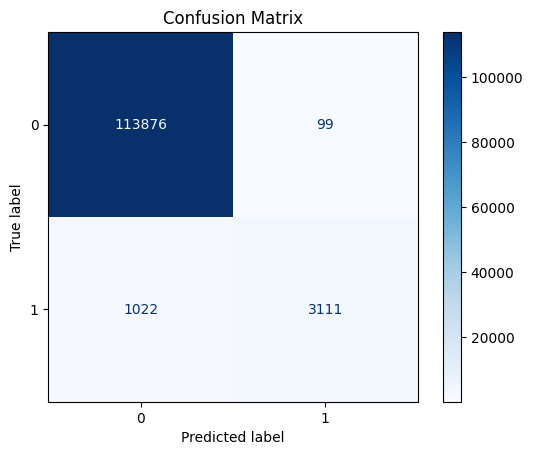

In [56]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Predict class labels for the validation set
y_pred = clf.predict(X_test)

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Display confusion matrix
disp = ConfusionMatrixDisplay(confusion_matrix=cm)
disp.plot(cmap='Blues')
plt.title("Confusion Matrix")
plt.show()

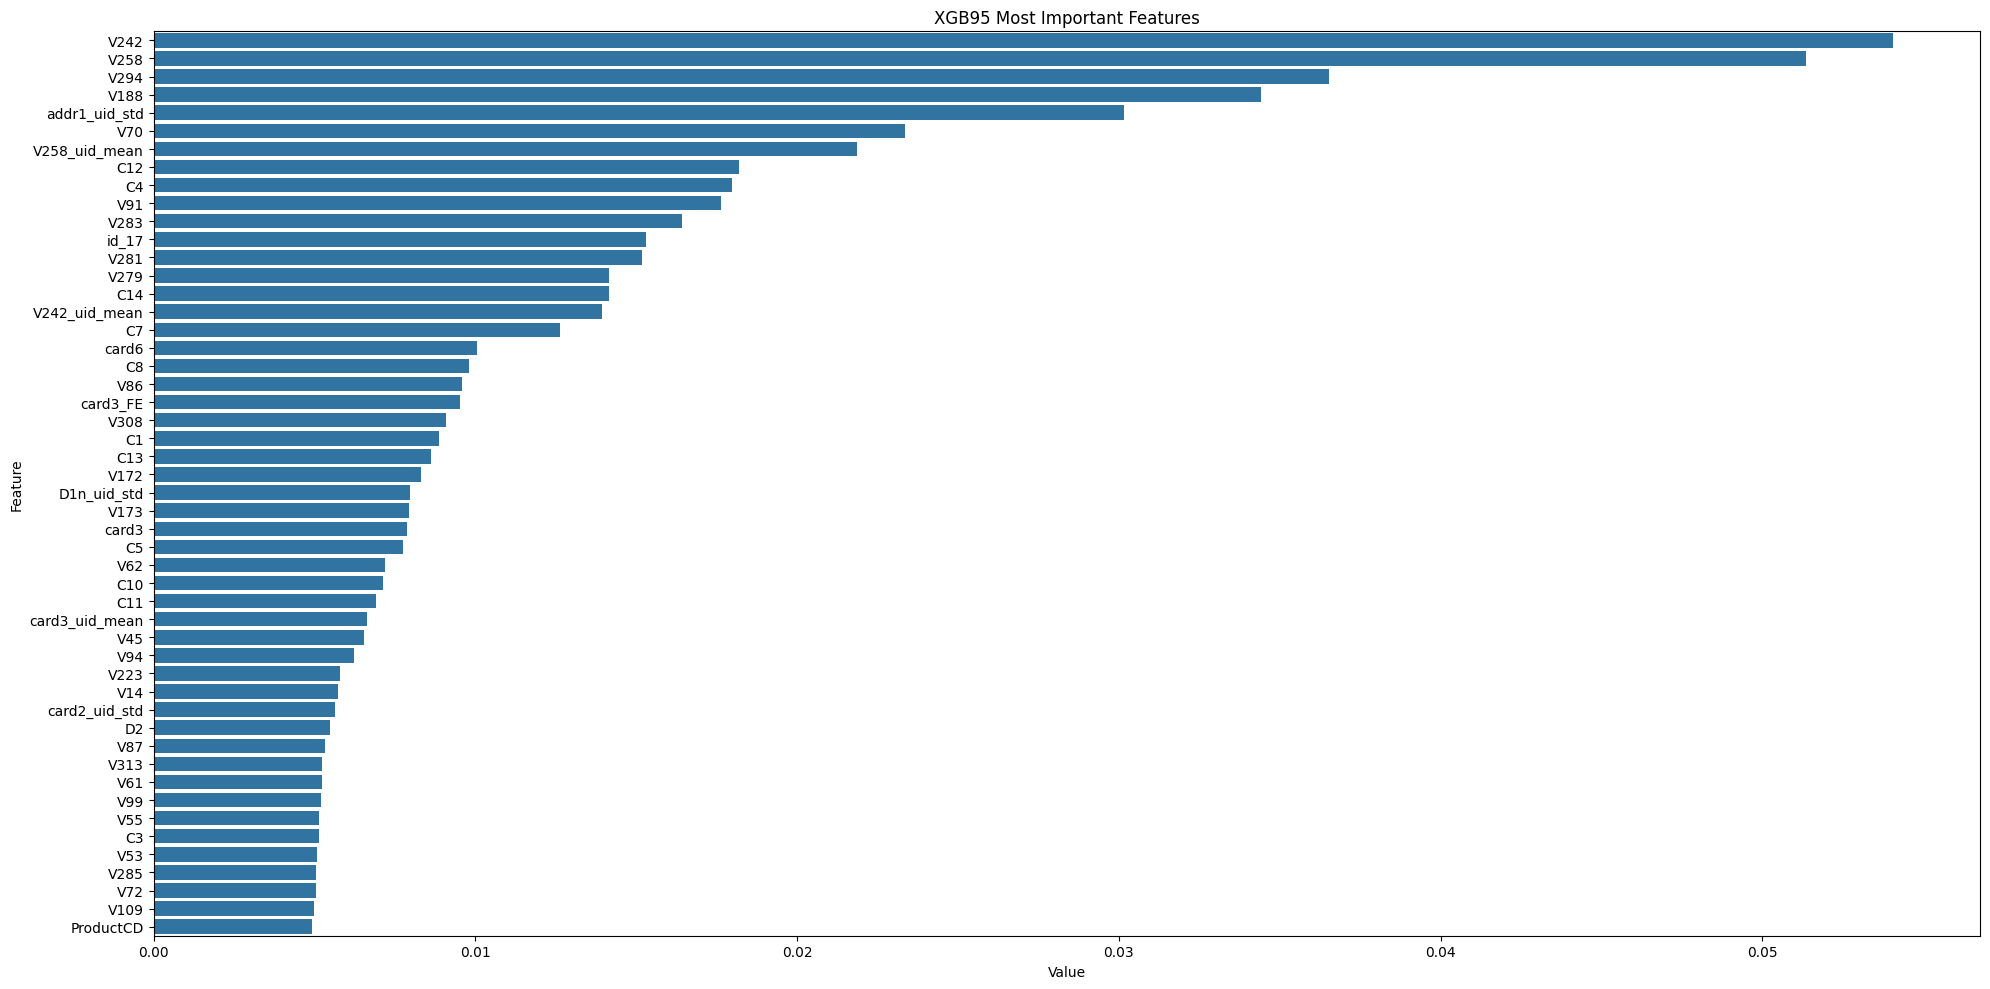

In [60]:
cols = X.columns.to_list()
feature_imp = pd.DataFrame(sorted(zip(clf.feature_importances_,cols)), columns=['Value','Feature'])
plt.figure(figsize=(20, 10))
sns.barplot(x="Value", y="Feature", data=feature_imp.sort_values(by="Value", ascending=False).iloc[:50])
plt.title('XGB95 Most Important Features')
plt.tight_layout()
plt.show()

In [61]:
#feature_imp.sort_values(by="Value", ascending=False).iloc[:50]

In [62]:
# Predict probabilities for the test set
tranz_test_probs = clf.predict_proba(tranz_test[X_train.columns])[:, 1]

# Fill the isFraud column with predicted probabilities
tranz_test['isFraud'] = tranz_test_probs

tranz_test[['TransactionID', 'isFraud']].to_csv('sub.csv', index=False)